# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 
---

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. There are many points of possible failure, and no perfect algorithm exists. Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Wrapper Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

('Number of faces detected:', 1)


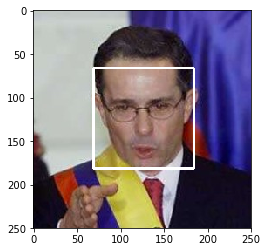

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Now, we test the performance of the `face_detector` function by answering the following questions:
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

As it can be seen below, algorithm is not great in human face detection due to relative high rate of false positives (11%). In other words, it mistakenly labels a consderable number of dogs as humans.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

detected_hh = [1 if face_detector(i) else 0 for i in human_files_short]
detected_hd = [1 if face_detector(i) else 0 for i in dog_files_short]
print ("{:.1f}% of the first 100 images in human_files have a detected human face".format(np.sum(detected_hh)))
print ("{:.1f}% of the first 100 images in dog_files have a detected human face".format(np.sum(detected_hd)))

98.0% of the first 100 images in human_files have a detected human face
11.0% of the first 100 images in dog_files have a detected human face


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). This is not a reasonable expectation to pose on the user. We need a better algorithm with a better performance that works well under all situations including occlusions. To my opinion, the best approach would be to employ deep learning and CNN on a wide range of training images from various angles, exposure, and obscuration levels. 

Since this is too much to do for this project, I prefer to not implement this approach. Instead, I would like to quickly check if I can improve the algorithm performance using the different haarcascades classifiers provided with `OpenCV` (Haar and LBP) and then combining the results. In practice, if two classifiers find similar results we can combine them and give a higher score value to the combined result (voting). To improve the detection even more, I also used the classifiers to detect eyes, noses and mouths. If the algorithm can detect those inside the detected faces, we can also add more value to those faces.

In [7]:
# using several classifiers 
clf1 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml') # face-haar
clf2 = cv2.CascadeClassifier('lbpcascades/lbpcascade_frontalface.xml') # face-lbp
clf3 = cv2.CascadeClassifier('cascades/Mouth.xml') # Mouth
clf4 = cv2.CascadeClassifier('cascades/Nose.xml') # Nose
clf5 = cv2.CascadeClassifier('cascades/Eyes.xml') # Eyes

def face_detector2(clf, img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = clf.detectMultiScale(gray, scaleFactor = 1.2)
    return len(faces) > 0

clfs = [clf1, clf2, clf3, clf4, clf5]
detected_hh_all = []
detected_hd_all =[]
for i in clfs:
    detected_hh = [1 if face_detector2(i, j) else 0 for j in human_files_short]
    detected_hd = [1 if face_detector2(i, j) else 0 for j in dog_files_short]
    detected_hh_all.append(detected_hh)
    detected_hd_all.append(detected_hd)

# voting by classifiers (trial and error)
detected_hh_ensemble = map(round, np.average(detected_hh_all, axis=0, weights=[3./5, 1./5, 1./20, 2./20, 1./20]))
detected_hd_ensemble =  map(round, np.average(detected_hd_all, axis=0, weights=[3./5, 1./5, 1./20, 2./20, 1./20]))

print ("{:.1f}% of the first 100 images in human_files have a detected human face".format(np.sum(detected_hh_ensemble)))
print ("{:.1f}% of the first 100 images in dog_files have a detected human face".format(np.sum(detected_hd_ensemble)))

95.0% of the first 100 images in human_files have a detected human face
5.0% of the first 100 images in dog_files have a detected human face


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

Now we test the performance of our `dog_detector` function. As we can see below, the dog_detector function based on pre-trained ResNet-50 model works quite well as it only makes one mistake in 200 human and dog images.

In [12]:
detected_dh = [1 if dog_detector(i) else 0 for i in human_files_short]
detected_dd = [1 if dog_detector(i) else 0 for i in dog_files_short]
print "{:.1f}% of the first 100 images in human_files have a detected dog face".format(np.sum(detected_dh))
print "{:.1f}% of the first 100 images in dog_files have a detected dog face".format(np.sum(detected_dd))

1.0% of the first 100 images in human_files have a detected dog face
100.0% of the first 100 images in dog_files have a detected dog face


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds. In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:21<00:00, 39.27it/s]


### Image Augmentationm

Using augmentation technique has a great impact on performance.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    rescale=1.1) 

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    rescale=1.1) 

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

### Model Architecture

Here we create a CNN to classify dog breed. I used paperspace cloud for optimizing my DL model architecture. I started to create a skeleton for my model by making a few high-level decisions including:

* Number of convolution layers: I decided to have more than 5 convolution layers (5 or 6) to capture more complex features important for classification such as eye and ear patterns. I set stride as default (equals 1) and padding as the `same` to create convolutional layer with the same width and height as the previous layer.
* Maxpooling layer: I added a maxpooling layer after each convolution layer to reduce dimensionality and potential overfitting.
* Batch normalization: I have applied batch normalization technique at the end for adjusting and scaling the activations. [This](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c) is a good brief summary to batch noralization technique.
* GAP layer: I added a global average pooling layer at the end of convolution layers to summarize the content and save it in a vector. 
* Number of fully connected layers: I decided to use an additional dense layer with higher number of hidden units to provide more flexibility for the model to detect the breed.

I have used [Hyperopt](https://github.com/hyperopt/hyperopt/wiki/FMin) package for hyperparameter tuning. I created a search space with the following variables:

* Number of layers: 5, 6
* Dropout value
* Kernel size: 2, 3, 4
* Optimizer: adadelta, adam, rmsprop
* Activation function: relu, tanh

Below is the code I ran on cloud:

In [15]:
from keras.callbacks import ModelCheckpoint  
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metraics import roc_auc_score
import sys


space = {'choice': hp.choice('num_layers',
                    [ {'layers':'five', },
                      {'layers':'six', }]),
         
            'kernel_size': hp.choice('kernel_size', [2,3,4]),

            'units1': 8,
            'units2': 16,
            'units3': 32,
            'units4': 64,
            'units5': 128,
            'units6': 256,

            'dropout1': hp.uniform('dropout1', .25, .75),
            'batch_size' : 32,
            'nb_epochs' :  10,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': hp.choice('activation',['relu', 'tanh'])
        }

def create_model(params):  
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.layers import Dropout, Flatten, Dense, Dropout
    from keras.models import Sequential
    from keras.layers.normalization import BatchNormalization
    
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop

    print ('Params testing: ', params)
    
    model = Sequential()
    model.add(Conv2D(filters=params['units1'], 
                     kernel_size=params['kernel_size'], 
                     padding='same', 
                     activation=params['activation'], 
                     input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=params['units2'], 
                     kernel_size=params['kernel_size'], 
                     padding='same', 
                     activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=params['units3'], 
                     kernel_size=params['kernel_size'], 
                     padding='same', 
                     activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=params['units4'], 
                     kernel_size=params['kernel_size'], 
                     padding='same', 
                     activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=params['units5'], 
                     kernel_size=params['kernel_size'], 
                     padding='same', 
                     activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    if params['choice']['layers']== 'six':
        model.add(Conv2D(filters=params['units6'], 
                         kernel_size=params['kernel_size'], 
                         padding='same', 
                         activation=params['activation']))
        model.add(MaxPooling2D(pool_size=2))
        model.add(BatchNormalization())   

    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(Dense(133, activation='softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_aug.hdf5', verbose=1, 
                                   save_best_only=True)
    model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=params['batch_size']),
                        steps_per_epoch=train_tensors.shape[0] // params['batch_size'],
                        epochs=params['nb_epochs'], verbose=2, callbacks=[checkpointer],
                        validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=params['batch_size']),
                        validation_steps=valid_tensors.shape[0] // params['batch_size'])
    
    model.load_weights('saved_models/weights.best.from_scratch_aug.hdf5')
    dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
    print('\n Test accuracy: %.4f%%' % test_accuracy)

    return {'loss': -test_accuracy, 'status': STATUS_OK}


trials = Trials()
best = fmin(create_model, space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

Here was the output:

`{'activation': 0, 'dropout1': 0.3551976459658954, 'kernel_size': 1, 'num_layers': 1, 'optimizer': 2}`

corresponding to:

`{'activation': relu, 'dropout1': 0.3551976459658954, 'kernel_size': 3, 'num_layers': 6, 'optimizer': 'rmsprop'}`

I then designed my architecture based on the results of the previous step as following:

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 8)       32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        4640      
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We train our model in the code cell below. We used model checkpointing to save the model that attains the best validation loss.

In [17]:
from keras.callbacks import ModelCheckpoint   

batch_size = 16
epochs = 15

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_aug.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/15
 - 177s - loss: 4.7759 - acc: 0.0355 - val_loss: 4.6089 - val_acc: 0.0361

Epoch 00001: val_loss improved from inf to 4.60890, saving model to saved_models/weights.best.from_scratch_aug.hdf5
Epoch 2/15
 - 177s - loss: 4.2448 - acc: 0.0634 - val_loss: 4.0658 - val_acc: 0.0647

Epoch 00002: val_loss improved from 4.60890 to 4.06582, saving model to saved_models/weights.best.from_scratch_aug.hdf5
Epoch 3/15
 - 177s - loss: 3.8918 - acc: 0.1072 - val_loss: 3.9375 - val_acc: 0.1136

Epoch 00003: val_loss improved from 4.06582 to 3.93753, saving model to saved_models/weights.best.from_scratch_aug.hdf5
Epoch 4/15
 - 177s - loss: 3.6440 - acc: 0.1391 - val_loss: 3.7034 - val_acc: 0.1343

Epoch 00004: val_loss improved from 3.93753 to 3.70343, saving model to saved_models/weights.best.from_scratch_aug.hdf5
Epoch 5/15
 - 179s - loss: 3.4105 - acc: 0.1787 - val_loss: 3.8546 - val_acc: 0.1392

Epoch 00005: val_loss did not improve
Epoch 6/15
 - 178s - loss: 3.2109 - acc: 0.2046 - val_lo

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch_aug.hdf5')

### Test the Model

We tried out our model on the test dataset of dog images. Very good score with this little effort but as we will see later, much worse performance comapred to highly optimized Transfer Learning based models!

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.0383%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images. 

We used transfer learning to create a CNN using `Resnet50` bottleneck features.  

### Obtain Bottleneck Features

In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

In [25]:
bottleneck_features = np.load('bottleneck_features/DogResNet50Data.npz')
train_ResNet = bottleneck_features['train']
valid_ResNet = bottleneck_features['valid']
test_ResNet = bottleneck_features['test']

### Model Architecture

Again, we create a CNN to classify dog breed but we use ResNet50 pre-trained model this time. The dog dataset is relatively small and has significant overlap with a subset of the ImageNet categories. In this scenario, we should slice off the end of the network and add a new classification layer with 133 nodes. This way, we train only the weights in this layer and freeze all the weights in the other layers. So, our model will use the output of the last max pooling layer from the pre-trained model as input. Then, it is reasonable to use a GAP layer to reduce dimensionality and a fully-connected layer with 133 nodes and `sigmoid` activation function to estimate the most probable breeds. 

I tried a few other architectures like adding a few FC layers or convolutional layers. But eventually, this simple structure returned the best performance as the pre-trained models are deep enough.

In [26]:
ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [27]:
ResNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet_model.fit(train_ResNet, train_targets, 
          validation_data=(valid_ResNet, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 0.79539, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 00001: val_loss improved from 0.79539 to 0.71355, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 00002: val_loss improved from 0.71355 to 0.70819, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 00003: val_loss improved from 0.70819 to 0.64259, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss di

### Load the Model with the Best Validation Loss

In [29]:
ResNet_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### Test the Model

We now try out our model on the test dataset of dog images. Good test accuracy!

In [30]:
# get index of predicted dog breed for each image in test set
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.0000%


### Predict Dog Breed with the Model

We now write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 4, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to our chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be `Resnet50`.

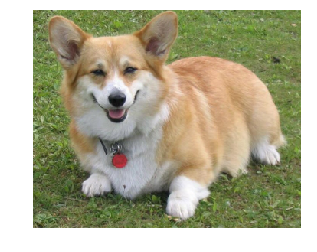

Label:  Pembroke_welsh_corgi
Prediction:
Pembroke_welsh_corgi : 94.44%
Cardigan_welsh_corgi : 5.41%
Icelandic_sheepdog : 0.11%


In [34]:
from extract_bottleneck_features import *
from random import randint
from __future__ import print_function

N = 3 # The N most probable breeds
def dog_breed(img_path):
    features = extract_Resnet50(path_to_tensor(img_path))
    ResNet_prediction = ResNet_model.predict(features)[0]
    breeds = [dog_names[i] for i in np.argsort(ResNet_prediction)[::-1][:N]]
    confidence = np.sort(ResNet_prediction)[::-1][:N]
    return zip(breeds, confidence)

def im_show(img_path):
    img = image.load_img(img_path)
    plt.axis('off')
    imgplot = plt.imshow(img)
    plt.show()
    return

# let's test the function
random_int = randint(0, len(test_files))
random_image = test_files[random_int]
im_show(random_image)
item_index = np.where(test_targets[random_int]==1)
print ('Label: ', dog_names[item_index[0][0]])
print ('Prediction:')
for i,j in dog_breed(random_image): print (i,':', '{:.2f}%'.format(j*100))

---
<a id='step5'></a>
## Step 5: Wrapper

We finally write a wrapper algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [35]:
# load filenames in shuffled human dataset
sample_files = np.array(glob("sample_images/*"))
random.shuffle(sample_files)

# print statistics about the dataset
print('There are %d total images.' % len(sample_files))

There are 12 total images.


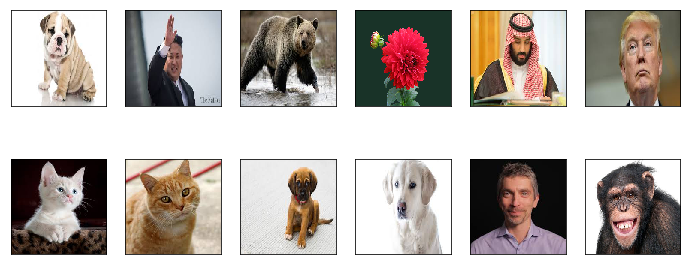

In [36]:
fig = plt.figure(figsize=(12,5))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    img = image.load_img(sample_files[i], target_size=(224, 224))
    ax.imshow(np.squeeze(img))

In [37]:
from __future__ import print_function

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def dog_breed(img_path):
    features = extract_Resnet50(path_to_tensor(img_path))
    ResNet_prediction = ResNet_model.predict(features)[0]
    breeds = [dog_names[i] for i in np.argsort(ResNet_prediction)[::-1][:N]]
    confidence = np.sort(ResNet_prediction)[::-1][:N]
    return zip(breeds, confidence)

def breed_detector(img_path):
    im_show(img_path)
    if dog_detector(img_path):
        print("Detected a dog")
        print("Identifying the most probable breed...")
        breeds = dog_breed(img_path)
        for i,j in breeds: print (i,':', '{:.2f}%'.format(j*100))
        return 
    elif face_detector(img_path):
        print("Detected a human face")
        print("Identifying the most resembling breeds ")
        breeds = dog_breed(img_path)
        for i,j in breeds: print (i,':', '{:.2f}%'.format(j*100))
        return 
    else:
        print("Error! No dog or human face detected")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, we will take our new algorithm for a spin!  

### Test our Algorithm on Sample Images!

We now test our algorithm on a few images. The model's performance seems good. It does a good job in dog and human face detection. Even though its face detection algorithm can be improved using more complex deep learning models. When we check its prediction for a few images, we notice that its peformance is affected by backgroud features. So, another way of improvement might be to narrow the ROI to the detected face region only. The last improvement I can think of would be to retrain the whole model rather than using the pre-trained weights.

Let's stop auto-scrolling

In [38]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

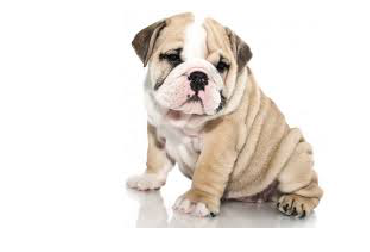

Detected a dog
Identifying the most probable breed...
Bulldog : 86.56%
Neapolitan_mastiff : 4.99%
Lhasa_apso : 4.91%
----------------


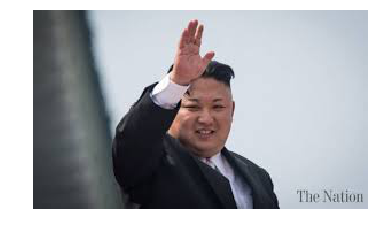

Detected a human face
Identifying the most resembling breeds 
Silky_terrier : 78.03%
Xoloitzcuintli : 7.55%
Maltese : 3.50%
----------------


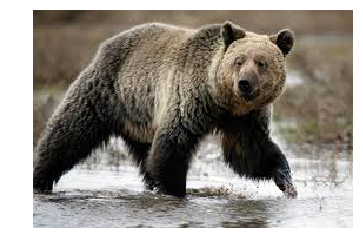

Error! No dog or human face detected
----------------


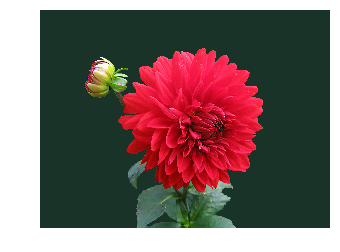

Error! No dog or human face detected
----------------


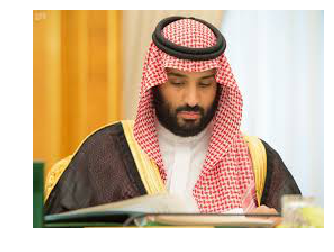

Detected a human face
Identifying the most resembling breeds 
Beagle : 74.25%
Dachshund : 24.52%
Chihuahua : 0.21%
----------------


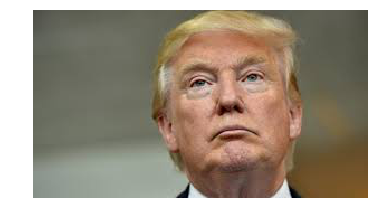

Detected a human face
Identifying the most resembling breeds 
Bullmastiff : 17.17%
Dachshund : 15.89%
Chinese_crested : 15.33%
----------------


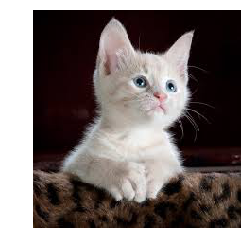

Error! No dog or human face detected
----------------


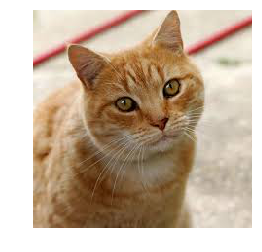

Error! No dog or human face detected
----------------


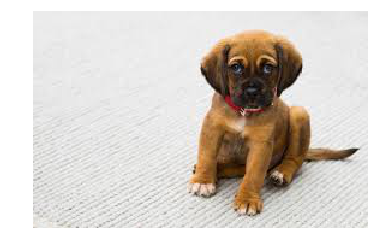

Detected a dog
Identifying the most probable breed...
Leonberger : 51.25%
Bloodhound : 20.42%
Bullmastiff : 13.78%
----------------


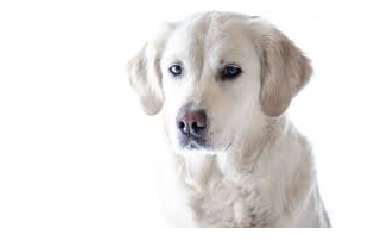

Detected a dog
Identifying the most probable breed...
Labrador_retriever : 86.28%
Anatolian_shepherd_dog : 8.83%
Kuvasz : 3.16%
----------------


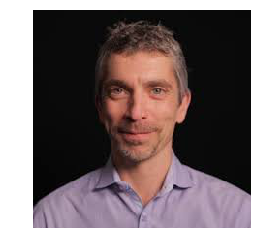

Detected a human face
Identifying the most resembling breeds 
American_eskimo_dog : 31.04%
Silky_terrier : 27.07%
Xoloitzcuintli : 6.79%
----------------


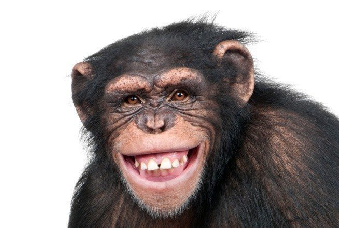

Error! No dog or human face detected
----------------


In [39]:
for i in sample_files:
    breed_detector(i)
    print ('----------------')